In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog


car_image_dirs = ["training"]
car_image_locations = glob.glob("./training/vehicles/**/*.png", recursive=True)
non_car_image_locations = glob.glob("./training/non-vehicles/**/*.png",recursive=True)

In [4]:
def read_image(filename):
    return mpimg.imread(filename)
    
car_images = [read_image(image) for image in car_image_locations]
non_car_images = [read_image(image) for image in non_car_image_locations]

In [5]:
def spatial_color_bin_feature(img,size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1,color2,color3))

def color_hist_feature(img, nbins=32):
    chan1 = np.histogram(img[:,:,0], bins=nbins)
    chan2 = np.histogram(img[:,:,1], bins=nbins)
    chan3 = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((chan1[0], chan2[0], chan3[0]))
    return hist_features

def hog_feature(img, orient=9, pix_per_cell=8, cell_per_block=2):
    hog_features = []
    for channel in range(img.shape[2]):
      hog_features.append(hog(img[:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=False, feature_vector=True))
    return np.ravel(hog_features)

def feature_vector(img):
    converted_color_space = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    resized_img = cv2.resize(converted_color_space, (64, 64))
    return np.concatenate( (color_hist_feature(resized_img), hog_feature(resized_img), spatial_color_bin_feature(resized_img)))



In [6]:
car_features = [ feature_vector(img) for img in car_images]
non_car_features = [feature_vector(img) for img in non_car_images]

/Users/mccuisto/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [7]:
from sklearn.preprocessing import StandardScaler


X = np.vstack([car_features,non_car_features]).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(non_car_features))))


In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
svc.fit(X_train, y_train)
print("shape: X_train: ", X_train.shape)
print("accuracy:", sum( svc.predict(X_test) == y_test ) / len(y_test))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


/Users/mccuisto/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


shape: X_train:  (14208, 8460)
accuracy: 0.991272522523
Test Accuracy of SVC =  0.9913


In [46]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 600], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def generate_windows(img, window_sizes):
    windows = []
    for size in window_sizes:
        windows += slide_window(img, xy_window=size, xy_overlap=(0.75,0.75))
    return windows

In [47]:
def search_windows(img,window_sizes):
    windows = generate_windows(img, window_sizes)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = feature_vector(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    #print("detected {} out of {}".format(len(on_windows),len(windows)))
    return on_windows

In [59]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
from collections import deque

def scale_jpg(img):
    return img.astype(np.float32)/255

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def pipeline(img,previous_heatmaps=deque(),frame_count=2):
  cp = np.copy(img)
  scaled = scale_jpg(cp)
  window_size_scales = [1.0, 2.0, 3.0]
  window_sizes = [ (int(i * 64.0), int(i * 64.0)) for i in window_size_scales]
  print(window_sizes)
  boxes = search_windows(scaled,window_sizes)
  heat = np.zeros_like(img[:,:,0]).astype(np.float)
  heat = add_heat(heat,boxes)
  heat = apply_threshold(heat,1)
  heatmap = np.clip(heat, 0, 255)
  if len(previous_heatmaps) > frame_count:
    previous_heatmaps.popleft()
  
  previous_heatmaps.append(heatmap)

  summed_heatmap = np.zeros_like(heatmap)
  for previous_heatmap in previous_heatmaps:
    summed_heatmap = np.add(previous_heatmap, summed_heatmap)
  labels = label(summed_heatmap)
  return draw_labeled_bboxes(img, labels)

[(64, 64), (128, 128), (192, 192)]
[(64, 64), (128, 128), (192, 192)]
[(64, 64), (128, 128), (192, 192)]
[(64, 64), (128, 128), (192, 192)]
[(64, 64), (128, 128), (192, 192)]
[(64, 64), (128, 128), (192, 192)]


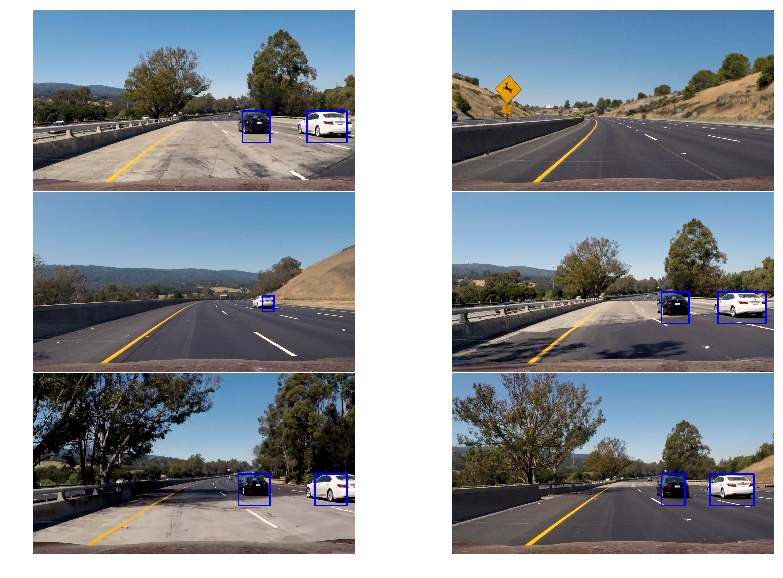

In [60]:
%matplotlib inline
test_images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(15,10))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, image in enumerate(test_images):
    axs[i].imshow(pipeline(mpimg.imread(image),previous_heatmaps=deque()))
    axs[i].axis('off')
#plt.savefig('examples/test_image_results.jpg')

In [61]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
    
    
previous_frames = deque([])
def multiframe_pipeline(img):
    return pipeline(img, previous_frames)
video_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(multiframe_pipeline)
%time clip.write_videofile(video_output, audio=False)

[(64, 64), (128, 128), (192, 192)]
[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


  0%|          | 0/39 [00:00<?, ?it/s]

[(64, 64), (128, 128), (192, 192)]


  3%|▎         | 1/39 [00:03<02:04,  3.27s/it]

[(64, 64), (128, 128), (192, 192)]


  5%|▌         | 2/39 [00:06<02:02,  3.30s/it]

[(64, 64), (128, 128), (192, 192)]


  8%|▊         | 3/39 [00:09<01:58,  3.30s/it]

[(64, 64), (128, 128), (192, 192)]


 10%|█         | 4/39 [00:13<01:54,  3.28s/it]

[(64, 64), (128, 128), (192, 192)]


 13%|█▎        | 5/39 [00:16<01:51,  3.27s/it]

[(64, 64), (128, 128), (192, 192)]


 15%|█▌        | 6/39 [00:19<01:47,  3.25s/it]

[(64, 64), (128, 128), (192, 192)]


 18%|█▊        | 7/39 [00:22<01:43,  3.25s/it]

[(64, 64), (128, 128), (192, 192)]


 21%|██        | 8/39 [00:26<01:40,  3.25s/it]

[(64, 64), (128, 128), (192, 192)]


 23%|██▎       | 9/39 [00:29<01:37,  3.26s/it]

[(64, 64), (128, 128), (192, 192)]


 26%|██▌       | 10/39 [00:32<01:34,  3.26s/it]

[(64, 64), (128, 128), (192, 192)]


 28%|██▊       | 11/39 [00:35<01:31,  3.25s/it]

[(64, 64), (128, 128), (192, 192)]


 31%|███       | 12/39 [00:39<01:27,  3.25s/it]

[(64, 64), (128, 128), (192, 192)]


 33%|███▎      | 13/39 [00:42<01:24,  3.24s/it]

[(64, 64), (128, 128), (192, 192)]


 36%|███▌      | 14/39 [00:45<01:22,  3.29s/it]

[(64, 64), (128, 128), (192, 192)]


 38%|███▊      | 15/39 [00:49<01:20,  3.36s/it]

[(64, 64), (128, 128), (192, 192)]


 41%|████      | 16/39 [00:52<01:18,  3.40s/it]

[(64, 64), (128, 128), (192, 192)]


 44%|████▎     | 17/39 [00:56<01:15,  3.41s/it]

[(64, 64), (128, 128), (192, 192)]


 46%|████▌     | 18/39 [00:59<01:10,  3.35s/it]

[(64, 64), (128, 128), (192, 192)]


 49%|████▊     | 19/39 [01:02<01:07,  3.36s/it]

[(64, 64), (128, 128), (192, 192)]


 51%|█████▏    | 20/39 [01:06<01:04,  3.37s/it]

[(64, 64), (128, 128), (192, 192)]


 54%|█████▍    | 21/39 [01:09<00:59,  3.33s/it]

[(64, 64), (128, 128), (192, 192)]


 56%|█████▋    | 22/39 [01:12<00:56,  3.34s/it]

[(64, 64), (128, 128), (192, 192)]


 59%|█████▉    | 23/39 [01:16<00:54,  3.41s/it]

[(64, 64), (128, 128), (192, 192)]


 62%|██████▏   | 24/39 [01:19<00:51,  3.45s/it]

[(64, 64), (128, 128), (192, 192)]


 64%|██████▍   | 25/39 [01:23<00:47,  3.42s/it]

[(64, 64), (128, 128), (192, 192)]


 67%|██████▋   | 26/39 [01:26<00:45,  3.47s/it]

[(64, 64), (128, 128), (192, 192)]


 69%|██████▉   | 27/39 [01:30<00:43,  3.62s/it]

[(64, 64), (128, 128), (192, 192)]


 72%|███████▏  | 28/39 [01:34<00:38,  3.52s/it]

[(64, 64), (128, 128), (192, 192)]


 74%|███████▍  | 29/39 [01:37<00:34,  3.45s/it]

[(64, 64), (128, 128), (192, 192)]


 77%|███████▋  | 30/39 [01:40<00:30,  3.42s/it]

[(64, 64), (128, 128), (192, 192)]


 79%|███████▉  | 31/39 [01:43<00:26,  3.37s/it]

[(64, 64), (128, 128), (192, 192)]


 82%|████████▏ | 32/39 [01:47<00:23,  3.35s/it]

[(64, 64), (128, 128), (192, 192)]


 85%|████████▍ | 33/39 [01:50<00:20,  3.37s/it]

[(64, 64), (128, 128), (192, 192)]


 87%|████████▋ | 34/39 [01:54<00:17,  3.41s/it]

[(64, 64), (128, 128), (192, 192)]


 90%|████████▉ | 35/39 [01:57<00:13,  3.39s/it]

[(64, 64), (128, 128), (192, 192)]


 92%|█████████▏| 36/39 [02:00<00:10,  3.39s/it]

[(64, 64), (128, 128), (192, 192)]


 95%|█████████▍| 37/39 [02:04<00:06,  3.38s/it]

[(64, 64), (128, 128), (192, 192)]


 97%|█████████▋| 38/39 [02:07<00:03,  3.39s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 2min 5s, sys: 1.04 s, total: 2min 6s
Wall time: 2min 8s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="./{0}" type="video/mp4">
</video>
""".format(video_output))